# 🦙 Projenin Hikâyesi
Bu projede **görüntü sınıflandırma** problemi çözüyoruz:

- **Veri seti:** *Alpaca Dataset Small* (Kaggle).  
  İçinde 2 sınıf var:  
  1. `alpaca`  
  2. `not alpaca`

- **Amaç:** Bir resimde **alpaca var mı yok mu?** kararını vermek.

- **Model yaklaşımı:**
  1. Önce **basit bir CNN** kurmayı denedik → doğruluk düşük kaldı.  
  2. Sonra **Transfer Learning (MobileNetV2)** kullandık → doğruluk ~%94’e ulaştı. 🎉

Bu notebook’ta adım adım şunları yapacağız:  
1. Veri setini yükle ve `train/val/test` olarak ayır.  
2. Resimleri hazırla (dataloader).  
3. Görselleri artır (augmentation).  
4. MobileNetV2 tabanlı modeli kur.  
5. Eğit ve val/test doğruluklarını izle.  
6. Karışıklık matrisi ile hataları gör.  
7. Grad-CAM ile modelin resimde nereye baktığını gör.  
8. Tek resim üzerinde tahmin yap.


In [14]:
import os, random, shutil, glob, math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from pathlib import Path
import scipy
import shutil, random
from PIL import Image
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


In [15]:
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [55]:
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

RAW_DIR = Path("/kaggle/input/alpaca-dataset-small")   # Kaggle "Input"
WORK_DIR = Path("/kaggle/working/alpaca-split")        # Bizim çalışma alanımız (train/val/test)
IMG_SIZE   = (160, 160)  # küçük resim = hızlı
BATCH_SIZE = 16
EPOCHS     = 42

print("TF:", tf.__version__)

TF: 2.18.0


## 2. Veriyi düzenle
- Kaggle'dan gelen veri yapısında asıl kök `dataset/`.
- İçinde `alpaca` ve `not alpaca` klasörleri var.
- Bunları `train / val / test` olarak %70 / %15 / %15 oranında böleceğiz.


In [56]:
# === 1. ÇALIŞMA KLASÖRÜNÜ TEMİZLE ===
import shutil
shutil.rmtree(WORK_DIR, ignore_errors=True)
WORK_DIR.mkdir(parents=True, exist_ok=True)

# === 2. DOĞRU KÖKÜ BELİRLE ===
CLASS_ROOT = RAW_DIR / "dataset"   # burada "alpaca" ve "not alpaca" klasörleri var
print("Sınıf kökü:", CLASS_ROOT)
print("Alt klasörler:", [d.name for d in CLASS_ROOT.iterdir() if d.is_dir()])

# === 3. BÖLMEYİ ÇALIŞTIR ===
split_dataset(CLASS_ROOT, WORK_DIR, train=0.7, val=0.15, seed=SEED)

# === 4. KONTROL ===
for split in ["train","val","test"]:
    classes = [d.name for d in (WORK_DIR/split).iterdir()]
    print(f"{split}: {classes}")


Sınıf kökü: /kaggle/input/alpaca-dataset-small/dataset
Alt klasörler: ['not alpaca', 'alpaca']
not alpaca: toplam=185 -> train=130, val=28, test=27
alpaca: toplam=142 -> train=99, val=21, test=22
train: ['not alpaca', 'alpaca']
val: ['not alpaca', 'alpaca']
test: ['not alpaca', 'alpaca']


## 3. Veri yükleme
- Resimleri aynı boyuta küçültüyoruz: **160×160** piksel.
- Batch size = 16 → model daha dengeli güncellemeler yapıyor.
- `train_ds`, `val_ds`, `test_ds` hazır olacak.


In [58]:
# === DATALOADER ===
train_ds = tf.keras.utils.image_dataset_from_directory(
    WORK_DIR/"train", image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    WORK_DIR/"val", image_size=IMG_SIZE, batch_size=BATCH_SIZE, seed=SEED
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    WORK_DIR/"test", image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, seed=SEED
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Sınıflar:", class_names)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1024, seed=SEED).cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Found 229 files belonging to 2 classes.
Found 49 files belonging to 2 classes.
Found 49 files belonging to 2 classes.
Sınıflar: ['alpaca', 'not alpaca']


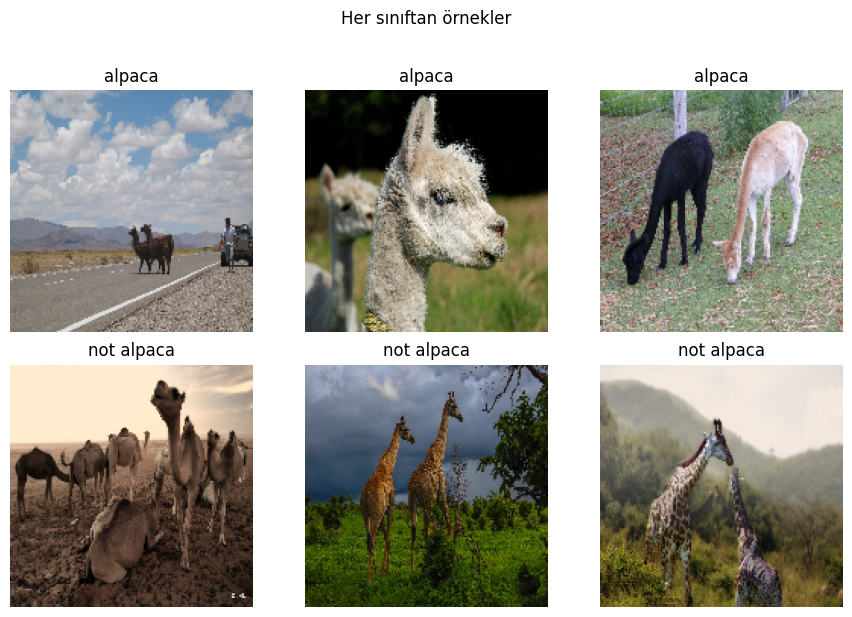

In [59]:
import matplotlib.pyplot as plt
import random
from tensorflow import keras

plt.figure(figsize=(9,6))

for idx, cls in enumerate(class_names):
    img_paths = list((WORK_DIR/"train"/cls).glob("*"))
    sample_paths = random.sample(img_paths, min(3, len(img_paths)))
    for j, p in enumerate(sample_paths):
        img = keras.utils.load_img(p, target_size=IMG_SIZE)
        plt.subplot(len(class_names), 3, idx*3 + j + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")

plt.suptitle("Her sınıftan örnekler", y=1.02)
plt.tight_layout(); plt.show()


## 4. Model (MobileNetV2)
- MobileNetV2 tabanını yüklüyoruz (ImageNet'te önceden eğitilmiş).
- Alt tabanı donduruyoruz → hazır bilgiyi kullan.
- Üstüne küçük Dense katman ekleyip bizim sınıflara göre eğitiyoruz.

In [60]:
# === 1. MODEL (Basit CNN + Augmentation) ===
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="augmentation")

def build_cnn(input_shape=(160,160,3), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x); x = layers.MaxPooling2D()(x); x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x); x = layers.MaxPooling2D()(x); x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x); x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="simple_cnn")
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss=keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    return model

model = build_cnn()
model.summary()


Model: "simple_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,234 (25.36 MB)

 Trainable params: 6,647,234 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Eğitim süreci
- EarlyStopping: Val hatası iyileşmezse dur.
- ReduceLROnPlateau: Val hatası duraklarsa öğrenme hızını azalt.
- En iyi model kaydediliyor.

Sonraki kod bloğunda eğitimi devam edecektir. Çünkü resimleri kitap gibi ezberlemesini istemiyoruz ve doğruluğun daha yüksek olmasını bekliyoruz.

Epoch 1/12


E0000 00:00:1758746991.481926      36 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/simple_cnn_1/dropout_12_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.4933 - loss: 1.4386 - val_accuracy: 0.5714 - val_loss: 0.6876
Epoch 2/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5649 - loss: 0.6896 - val_accuracy: 0.5714 - val_loss: 0.6824
Epoch 3/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5649 - loss: 0.6946 - val_accuracy: 0.5714 - val_loss: 0.6835
Epoch 4/12
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5649 - loss: 0.6887 - val_accuracy: 0.5714 - val_loss: 0.6830


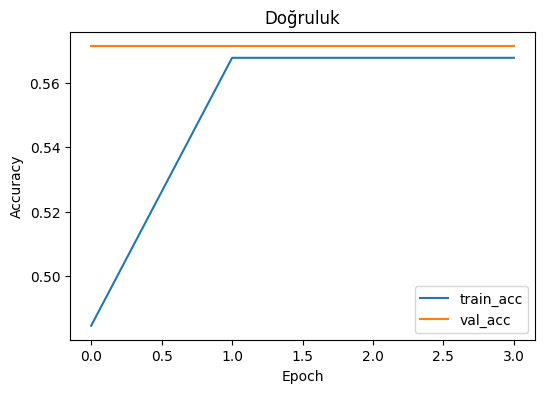

In [61]:
# === 2. EĞİTİM ===
ckpt_path = "/kaggle/working/best_cnn.keras"
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12,    # önce hızlı test için 5 yapabilirsin
    callbacks=callbacks,
    verbose=1
)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Doğruluk"); plt.show()


# 🎯 Neden Transfer Learning 

Önce basit bir CNN denedik; eğitim (train) artarken doğrulama (val) yerinde saydı → **overfitting**.
Bunu aşmak için **Transfer Learning** kullanıyoruz:

- **MobileNetV2**: ImageNet üzerinde önceden eğitilmiş “gözler”.
- Bizim küçük veri setimizde **daha az ezber, daha çok genelleme**.
- İki aşamalı eğitim:
  1) **Dondurulmuş taban** (+ küçük tepe): hızlı ve güvenli öğrenme.
  2) **İnce ayar (fine-tune)**: son katmanları aç, **küçük öğrenme hızı** ile dikkatlice uyarla.

> Hedef: Val/Test doğruluğunu yükseltirken **overfitting’i frenlemek**.


In [ ]:
IMG_TL = (160,160)
BATCH_SIZE = 16  # biraz daha küçük, genelde daha stabil
SEED = 42

# Dataloader'ı 160x160'a büyüt
train_up = train_ds.map(lambda x,y: (tf.image.resize(x, IMG_TL), y))
val_up   = val_ds.map(  lambda x,y: (tf.image.resize(x, IMG_TL), y))
test_up  = test_ds.map( lambda x,y: (tf.image.resize(x, IMG_TL), y))

# Performans: cache+prefetch (zaten vardıysa tekrarı sorun değil)
AUTOTUNE = tf.data.AUTOTUNE
train_up = train_up.cache().prefetch(AUTOTUNE)
val_up   = val_up.cache().prefetch(AUTOTUNE)
test_up  = test_up.cache().prefetch(AUTOTUNE)

# class_weight (train dengesizliği için)
counts = {c: len(list((WORK_DIR/"train"/c).glob("*"))) for c in class_names}
total = sum(counts.values()); k = len(class_names)
class_weight = {i: total/(k*counts[class_names[i]]) for i in range(k)}
print("class_weight:", class_weight)


# 🧊 1) Aşama-1 — Tabanı Dondur, Sadece Tepeyi Eğit

- `MobileNetV2` tabanını alıyoruz (`weights="imagenet"`).  
- `base.trainable = False` → Önceden öğrenilmiş özellikleri **donduruyoruz**.  
- Hafif **augmentation** (flip, rotation, zoom, contrast) → model ezberlemesin.  
- Üstüne şu katmanları ekliyoruz:  
  - `GlobalAveragePooling2D`  
  - `Dropout(0.2)`  
  - `Dense(softmax)` (çıkış)  
- Optimizer: `Adam(1e-3)`  
- Callback’ler:  
  - **EarlyStopping(monitor="val_accuracy")** → iyileşme yoksa dur.  
  - **ReduceLROnPlateau(monitor="val_loss")** → öğrenme hızını küçült.  

👉 İlk aşamada sadece **üst katmanı** eğitiyoruz. Taban sabit kalıyor.


In [ ]:
# ===== 1) Aşama-1: tabanı dondur, sadece tepeyi eğit =====
base = keras.applications.MobileNetV2(
    include_top=False, input_shape=(IMG_TL[0], IMG_TL[1], 3), weights="imagenet")
base.trainable = False  # büyük abiyi şimdilik dondur

# Hafif augmentation
aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.1),
], name="augmentation")

inputs = keras.Input(shape=(IMG_TL[0], IMG_TL[1], 3))
x = aug(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
tl_model = keras.Model(inputs, outputs, name="mobilenetv2_head")

tl_model.compile(optimizer=keras.optimizers.Adam(1e-3),
                 loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=["accuracy"])

cb1 = [
    keras.callbacks.ModelCheckpoint("/kaggle/working/tl_stage1.keras", save_best_only=True, monitor="val_accuracy"),
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=4, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
]

# 🪄 Son Katmanları Aç, Küçük LR ile İnce Ayar

- Artık `base.trainable = True`.  
- Ama hepsini açmak yerine, sadece **son ~30 katmanı serbest bırakıyoruz**.  
- Öğrenme hızı çok küçük: `Adam(1e-4)` → ince ayar.  
- Callback’ler:  
  - **EarlyStopping(monitor="val_loss")** → ezber başlamadan dur.  
  - **ReduceLROnPlateau** → hızını gerektiğinde küçült.  

👉 Böylece model, hazır bilgisini bozmaz ama bizim veri setine daha iyi uyum sağlar.


In [62]:

# ===== 2) Aşama-2: son katmanları aç, küçük LR ile ince ayar =====
base.trainable = True
for layer in base.layers[:-30]:   # son ~30 katmanı serbest bırak
    layer.trainable = False

tl_model.compile(optimizer=keras.optimizers.Adam(1e-4),  # küçük adımlar çok önemli
                 loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=["accuracy"])

cb2 = [
    keras.callbacks.ModelCheckpoint("/kaggle/working/tl_stage2.keras", save_best_only=True, monitor="val_accuracy"),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
]

hist2 = tl_model.fit(
    train_up, validation_data=val_up, epochs=15,
    class_weight=class_weight, callbacks=cb2, verbose=1
)

# ===== 3) Test (final sınavı) =====
test_loss, test_acc = tl_model.evaluate(test_up, verbose=0)
print(f"[Transfer Learning] Test Doğruluk: {test_acc:.4f} | Kayıp: {test_loss:.4f}")


class_weight: {0: 1.1565656565656566, 1: 0.8807692307692307}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 229ms/step - accuracy: 0.4849 - loss: 0.9746 - val_accuracy: 0.7551 - val_loss: 0.4896 - learning_rate: 0.0010
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7751 - loss: 0.5338 - val_accuracy: 0.8980 - val_loss: 0.3124 - learning_rate: 0.0010
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8191 - loss: 0.3768 - val_accuracy: 0.9388 - val_loss: 0.2383 - learning_rate: 0.0010
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8659 - loss: 0.3217 - val_accuracy: 0.9388 - val_loss: 0.1977 - learning_rate: 0.0010
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8919 - loss: 0.2607 - val_accuracy: 0.9388 - val_loss: 0.1756 - learning_rate: 0.0010
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9275 - loss: 0.1941 - val_accuracy: 0.9388 - val_loss: 0.1628 - lear

# 📊 4) Modeli Değerlendirme: Rapor ve Karışıklık Matrisi

Eğitim ve test doğruluğunu görmek güzel ama **hangi sınıfta hata yapıyor?** sorusunun cevabı için daha ayrıntılı inceleme yapıyoruz:

- **`classification_report`**:  
  - Her sınıf için `precision`, `recall`, `f1-score` değerlerini verir.  
  - Bu sayede hangi sınıfı daha iyi tanıdığını, hangisinde zorlandığını görürüz.

- **Karışıklık Matrisi (Confusion Matrix):**  
  - Satırlar = **gerçek sınıf**, sütunlar = **tahmin edilen sınıf**.  
  - Diyagonal (köşegen) üzerindeki değerler → doğru tahminler.  
  - Diyagonal dışındaki kutular → modelin yaptığı hatalar (ör. `alpaca`yı `not alpaca` sanmak).

👉 Bu görselleştirme ile modelin **nerelerde kafasının karıştığını** somut olarak görebiliriz.


              precision    recall  f1-score   support

      alpaca       0.95      0.91      0.93        22
  not alpaca       0.93      0.96      0.95        27

    accuracy                           0.94        49
   macro avg       0.94      0.94      0.94        49
weighted avg       0.94      0.94      0.94        49



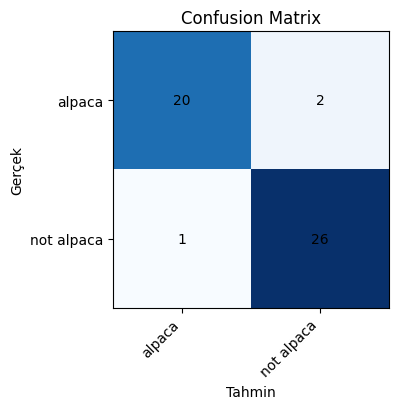

In [63]:

y_true = np.concatenate([y.numpy() for _, y in test_up], axis=0)
y_prob = tl_model.predict(test_up, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4.8,4.2))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j,i,cm[i,j],ha="center",va="center")
plt.xlabel("Tahmin"); plt.ylabel("Gerçek"); plt.tight_layout(); plt.show()


Yanlış sayısı: 3


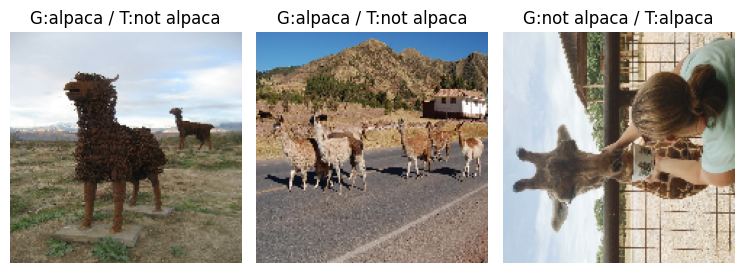

In [64]:
# test_up sırası, WORK_DIR/test dosya sırasıyla uyuşsun diye yolları topla
test_paths = []
for cls in class_names:
    test_paths += sorted([str(p) for p in (WORK_DIR/"test"/cls).glob("*")])

wrong_idx = np.where(y_true != y_pred)[0]
print("Yanlış sayısı:", len(wrong_idx))

n = min(12, len(wrong_idx))
if n > 0:
    plt.figure(figsize=(10,8))
    for i, idx in enumerate(wrong_idx[:n]):
        img = keras.utils.load_img(test_paths[idx], target_size=(IMG_TL[0], IMG_TL[1]))
        plt.subplot(3,4,i+1); plt.imshow(img); plt.axis("off")
        plt.title(f"G:{class_names[int(y_true[idx])]} / T:{class_names[int(y_pred[idx])]}")
    plt.tight_layout(); plt.show()


In [72]:
def make_gradcam_heatmap(img_array, full_model, feat_tensor, pred_index=None):
    grad_model = keras.models.Model(
        inputs=full_model.inputs,
        outputs=[feat_tensor, full_model.output]
    )

    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_out)            # dL/dA
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))      # kanal ortalaması
    conv_out = conv_out[0]                                    # (H, W, C)
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_out), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-8)
    return heatmap


/tmp/ipykernel_36/873866105.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  heatmap = np.uint8(255*heatmap); jet = cm.get_cmap("jet")


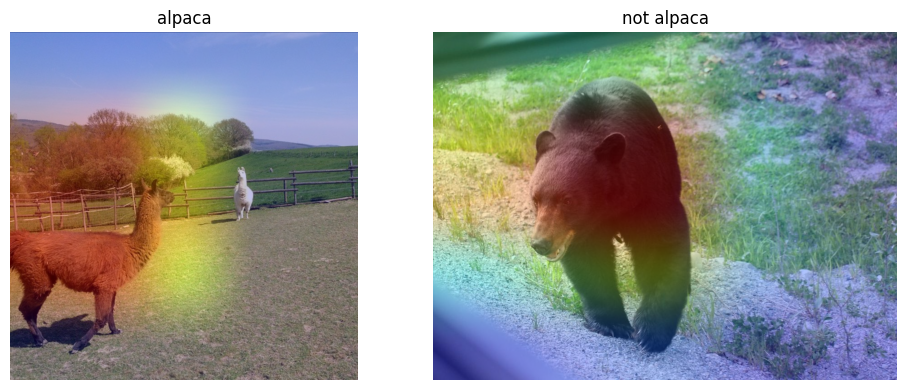

In [74]:
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    arr = keras.utils.img_to_array(img)
    return np.expand_dims(arr, axis=0)

# Her sınıftan 1 örnek seç
samples = []
for cls in class_names:
    files = list((WORK_DIR/"test"/cls).glob("*"))
    if files:
        samples.append(str(files[0]))

plt.figure(figsize=(10, 4))
for i, p in enumerate(samples):
    # 1) Giriş tensörü boyutuna göre resmi hazırla (IMG_TL = (160,160))
    arr = get_img_array(p, size=IMG_TL)

    # 2) Isı haritasını üret
    heat = make_gradcam_heatmap(arr, tl_model, feature_tensor)

    # 3) Bindir ve çiz
    cam_img = overlay(p, heat)
    plt.subplot(1, len(samples), i+1)
    plt.imshow(cam_img); plt.axis("off")
    plt.title(Path(p).parent.name)

plt.tight_layout(); plt.show()
